In [1]:
import numpy as np
import cv2
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.widgets import RectangleSelector
import math

In [2]:
np.random.seed(42)

n_components = 10

mat_files = sorted([file for file in os.listdir("data_np/") if file.endswith('.npy')])
idx = 17

image_sequence = np.load('data_np/' + mat_files[idx])
image_sequence = image_sequence[135:, :, :]
roi_coords = []

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


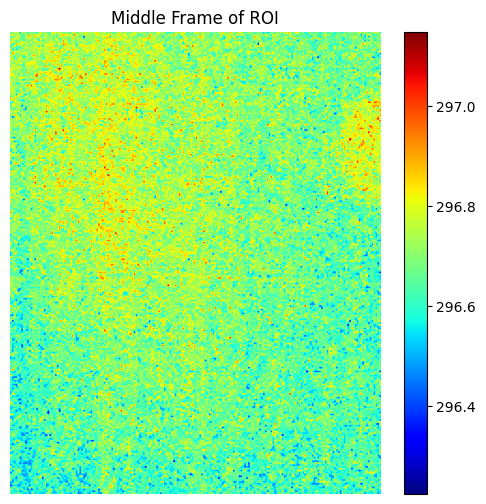

In [3]:
h, w, t = image_sequence.shape

middle_frame = image_sequence[:, :, t // 2]
frame_8bit = cv2.normalize(middle_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
colored = cv2.applyColorMap(frame_8bit, cv2.COLORMAP_JET)

roi = cv2.selectROI("Select ROI", colored, showCrosshair=True)
cv2.destroyAllWindows()

x, y, w_roi, h_roi = roi
image_sequence = image_sequence[y:y+h_roi, x:x+w_roi, :]

t = image_sequence.shape[2]
middle_frame = image_sequence[:, :, t // 2]

plt.figure(figsize=(6, 6))
plt.imshow(middle_frame, cmap='jet')
plt.title('Middle Frame of ROI')
plt.axis('off')
plt.colorbar()
plt.show()

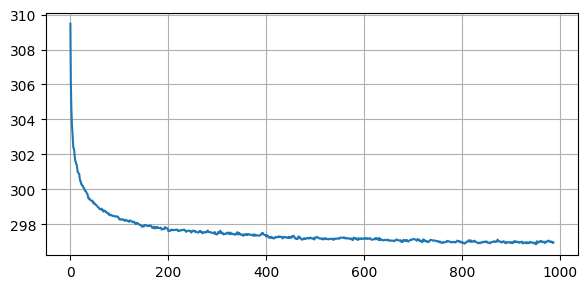

11


In [4]:
h, w, sequence_size = image_sequence.shape
plt.figure(figsize=(6, 3))
plt.plot(image_sequence.reshape(h * w, sequence_size)[5000,13:1000])
plt.grid(True)
plt.tight_layout()
plt.show()

diff = np.diff(image_sequence.reshape(h * w, sequence_size)[5000,:1000])
t_pulse = np.argmax(diff)
print(t_pulse)
t_pulse = 13

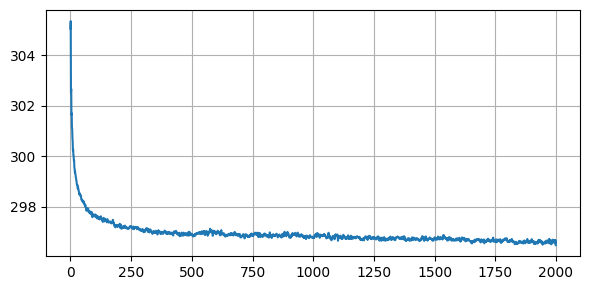

In [5]:
from scipy.signal import resample

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, t_pulse:]

imageMatrix = resample(imageMatrix, 2010, axis=1)
imageMatrix = imageMatrix[:, :-10]
plt.figure(figsize=(6, 3))
plt.plot(imageMatrix[5000,:])
plt.grid(True)
plt.tight_layout()
plt.show()

imageMatrix = imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True)

U, S, Vh = np.linalg.svd(imageMatrix, full_matrices=False)

Vh = Vh[:n_components, :]

principal_comp = np.matmul(imageMatrix, Vh.T)

pca_array = principal_comp.reshape(h, w, n_components)
pca_array = pca_array.transpose(2, 0, 1)

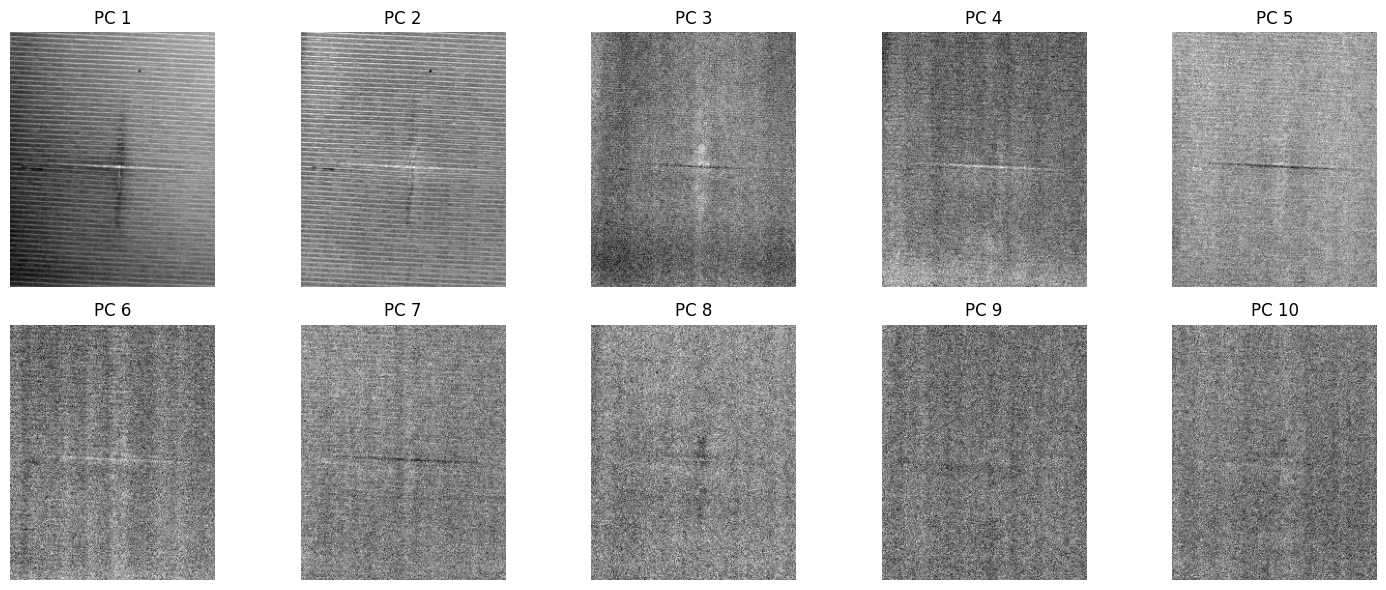

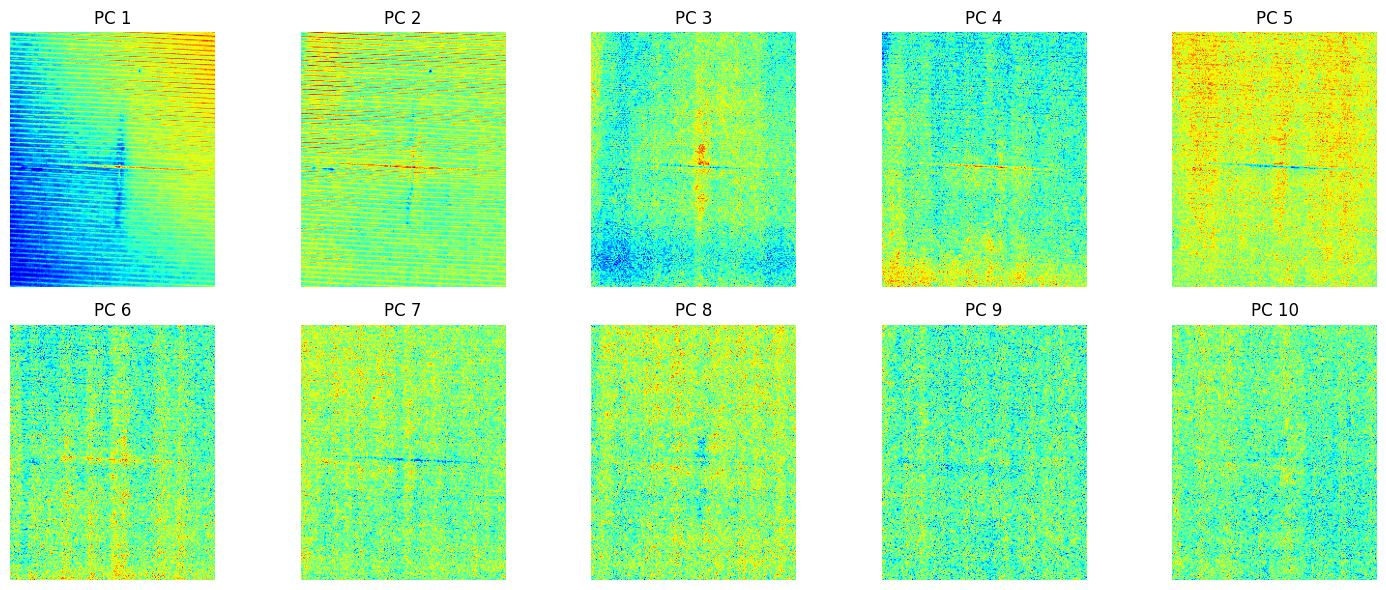

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

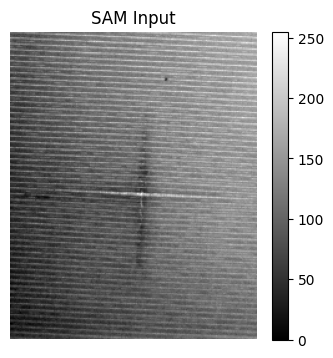

In [7]:
import torch
import cv2
import numpy as np
import os

comp = pca_array[0, :, :]

comp -= comp.min()
comp /= (comp.max() + 1e-8)
comp = (comp * 255).astype(np.uint8)

gray_8u = cv2.normalize(comp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
bgr = cv2.applyColorMap(gray_8u, cv2.COLORMAP_JET)
# img_rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
img_rgb = cv2.cvtColor(gray_8u, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(4, 4))
plt.imshow(gray_8u, cmap='gray')
plt.title(f'SAM Input')
plt.axis('off')
plt.colorbar()
plt.show()

/home/m123/anaconda3/envs/sa2va/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/m123/anaconda3/envs/sa2va/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Loading checkpoint shards: 100%|██████████| 4/4 [00:13<00:00,  3.42s/it]


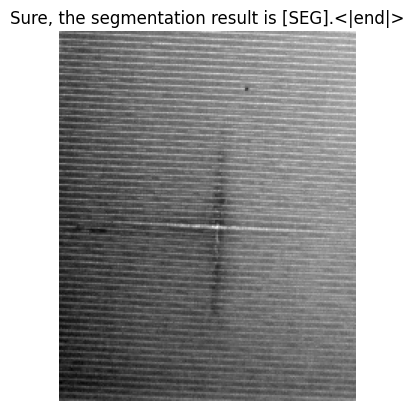

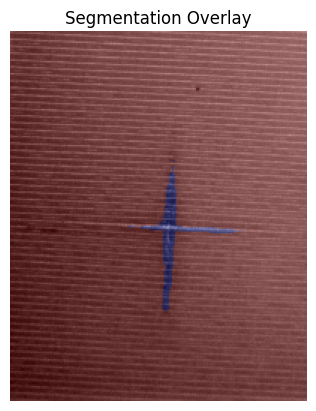

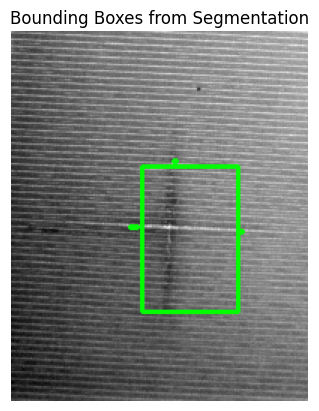

: 

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import numpy as np
import cv2

model_id = "ByteDance/Sa2VA-4B"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModel.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    use_flash_attn=True,
    low_cpu_mem_usage=True
).eval().to(device)

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, use_fast=False)

image = Image.fromarray(img_rgb).convert("RGB")
question = "<image> Inspect this thermal image for defects. Segment each defect and describe its type, size, and location. Return masks."

inputs = {
    "image": image,
    "text": question,
    "past_text": "",
    "mask_prompts": None,
    "tokenizer": tokenizer
}

with torch.no_grad():
    outputs = model.predict_forward(**inputs)

answer = outputs["prediction"]
masks = outputs.get("prediction_masks", None)

plt.imshow(image)
plt.title(answer)
plt.axis("off")
plt.show()

if masks and len(masks) > 0:
    mask_np = masks[0]
    if mask_np.dtype != np.uint8:
        mask_np = (mask_np * 255).clip(0, 255).astype(np.uint8)
    if mask_np.ndim == 3:
        mask_np = mask_np.squeeze()

    mask_colored = cv2.applyColorMap(mask_np, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.array(image), 0.6, mask_colored, 0.4, 0)
    plt.figure()
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Segmentation Overlay")
    plt.show()

    contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bbox_overlay = np.array(image).copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt) 
        cv2.rectangle(bbox_overlay, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure()
    plt.imshow(bbox_overlay)
    plt.axis("off")
    plt.title("Bounding Boxes from Segmentation")
    plt.show()